## Genetski algoritam

Zadatak: Genetskim algoritmom odrediti trougao maksimalne povrsine, upisan u elipsu:

$$ \frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$$
 
Resenje: Tri tacke trougla definisemo, redom, uglovima $\alpha$, $\beta$, $\gamma$ koji su u opsegu $[0, 2 \pi)$.

Za dati ugao $\theta$, tacka ce pripadati elipsi ako je

$$ x = a \cos \theta, \quad y = b \sin \theta$$
 
Uglove cemo da definisemo koriscenjem 12 bita. Prema tome duzina jednog hromozoma je L=36 .

In [581]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.stats import rankdata

import warnings
warnings.filterwarnings('ignore')

In [582]:
## Definicija osnovnih parametara algoritma.

N = 50 # broj jedinki u populaciji
L = 36 # duzina hromozoma
pc = 0.9 # verovatnoca ukrstanja
pm = 0.001 # vertovatnoca mutacije
G = 0.8 # procenat populacije koji se menja u narednoj generaciji

## Parametri elipse
a = 15
b = 3
a2 = 15 ** 2
b2 = 3 ** 2

### Osnovne funkcije za crtanje

In [583]:
# Funkcija koja iscrtava elipsu na prosledjenoj figuri.
def plot_elipse(fig, a, b):
    
    theta = np.linspace(0, 2*pi, 200)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    
    plt.figure(fig)
    plt.plot(x, y)

In [584]:
# Funkcija koja iscrtava trouglove na prosledjenoj figuri.
def plot_triangles(fig, X, Y, c, label=''):
    """
   X, Y : N x 3 : one row is one set of points (x1, x2, x3) or (y1, y2, y3)
    c : color
    """
    if X.ndim != Y.ndim:
        return
    
    if X.ndim == 1:
        plt.figure(fig)
        plt.plot([X[0], X[1], X[2], X[0]], 
                 [Y[0], Y[1], Y[2], Y[0]],
                color = c,
                label = label)
        return
    
    if X.shape[0] != Y.shape[0]:
        return
    
    plt.figure(fig)
    for i in range(X.shape[0]):
        plt.plot([X[i][0], X[i][1], X[i][2], X[i][0]], 
                 [Y[i][0], Y[i][1], Y[i][2], Y[i][0]],
                color = c)

In [585]:
# Funkcija koja crta najboljih n trouglova na prosledjenoj figuri.
def plot_best_triangles(fig, fitness, X, Y, n):
    
    if n > fitness.shape[0]:
        n = fitness.shape[0]
        
    ind = np.argsort(-fitness,axis=0)[:n]
    # Najbolji je zeleni, najgori je sivi.
    cmap = plt.cm.get_cmap('Accent', n)
    
    for i in range(n):
        plot_triangles(fig, X[ind[i], :], Y[ind[i], :], c = cmap(i), label = str(round(fitness[ind[i]], 2)))

### Inicijalizacija populacije

In [586]:
def generate_initial_population(N, L):
    population = np.empty((N,),  dtype=object)
    for i in range(N):
        population[i] = ("{0:0"+str(L)+"b}").format(int(np.random.uniform(0,1)*(2 ** L)))
    return population

### Evaluacija populacije i pomocne funkcije za interpretaciju rezultata

In [587]:
def extract_angles(population, L):
    N = population.shape[0]
    angles = np.zeros((N, 3))
    clen = L // 3
    for i in range(3):
        angles[:, i] = [int(chrom[i*clen:(i+1)*clen], 2) / (2**clen - 1) * 2 * pi for chrom in population]
    return angles

In [588]:
def evaluate_area(X, Y):
     
    a = np.sqrt(np.power(X[:, 0] - X[:, 1], 2) + np.power(Y[:, 0] - Y[:, 1], 2))
    b = np.sqrt(np.power(X[:, 2] - X[:, 1], 2) + np.power(Y[:, 2] - Y[:, 1], 2))
    c = np.sqrt(np.power(X[:, 0] - X[:, 2], 2) + np.power(Y[:, 0] - Y[:, 2], 2))
    
    s = (a + b + c) / 2
    
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [589]:
def evaluate_population(population, a, b):
    
    N = population.shape[0]
    L = len(population[0])
    X = np.zeros((N, 3))
    Y = np.zeros((N, 3))
    
    angles = extract_angles(population, L)
    
    for i in range(3):
        X[:, i] = a * np.cos(angles[:, i])
        Y[:, i] = b * np.sin(angles[:, i])
        
    return evaluate_area(X, Y), X, Y

### Funkcije za selektovanje jedinke na osnovu razlicitih algoritama 

Svaka funkcija vraca selektovan odgovarajuci broj jedinki.

In [609]:
def roulette_wheel(fitness, population, n, fig = None):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    """
    
    fitness_cumsum = np.cumsum(fitness)
    max_sum = np.sum(fitness)
    selected = np.empty((n,), dtype=object)
    
    if fig is not None:
        plt.figure(fig)
        plt.pie(fitness_cumsum)
    
    for i in range(n):
        tmp = np.random.uniform(0, 1) * max_sum
        ind = np.searchsorted(fitness_cumsum, tmp, side='left')
        selected[i] = population[i]
        
    return selected
    
def elitistic(fitness, population, n, percentages):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    percentages : with what percentage should each be included (percentages[0] = 50% means that
    best chromosome should take 50% of selected chromosomes and so on)
    """
    
    fitness_sorted_ind = np.argsort(fitness) # Ascending!
    #print(np.round_(fitness[fitness_sorted_ind], 2))
    percentages = (percentages * n).astype(int)
    percentages[0] += n - np.sum(percentages) # Account for lost spots due to rounding.
    
    selected = np.empty((n,), dtype=object)
    
    cumsum = 0
    for (i, p) in enumerate(percentages):
        ind = fitness_sorted_ind[-(1+i)]
        #print(np.round_(fitness[ind], 2))
        selected[cumsum:cumsum + p] = np.repeat(population[ind], p)
        cumsum += p
        
    return selected

def deterministic_selection(fitness, population, n):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    """
    
    replications = (fitness / np.sum(fitness) * n).astype(int)
    selected = np.empty((n,), dtype=object)
    best = np.argmax(replications) # index of best chromosome.
    free_slots = n - np.sum(replications)
    replications[best] += free_slots
    
    cumsum = 0
    for (i, rep) in enumerate(replications):
        selected[cumsum:cumsum + rep] = np.repeat(population[i], rep)
        cumsum += rep
        
    return selected
    
def stochastic_selection_with_replacement(fitness, population, n):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    """
    
    selected = np.empty((n,), dtype=object)
    free_slots = n - np.sum((fitness / np.sum(fitness) * n).astype(int))
    r = (fitness / np.sum(fitness) * n) - (fitness / np.sum(fitness) * n).astype(int)
    
    selected[0:(n-free_slots)] = deterministic_selection(fitness, population, n - free_slots)
    selected[n-free_slots:n] = roulette_wheel(r, population, free_slots)
    
    return selected

def stochastic_selection_without_replacement(fitness, population, n):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    """
    selected = np.empty((n,), dtype=object)
    free_slots = n - np.sum((fitness / np.sum(fitness) * n).astype(int))
    r = (fitness / np.sum(fitness) * n) - (fitness / np.sum(fitness) * n).astype(int)
    
    selected[0:(n-free_slots)] = deterministic_selection(fitness, population, n - free_slots)
    
    cur = n - free_slots
    i = 0
    while cur < n:
        if np.random.uniform(0, 1) <= r[i]:
            selected[cur] = population[i]
            cur += 1
        i = (i + 1) % population.shape[0]
        
    return selected

def tournament(fitness, population, n):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    """
    N = population.shape[0]
    tournament_ind = np.arange(N)
    np.random.shuffle(tournament_ind)
    tournament_ind = np.array_split(tournament_ind, n)
    selected = np.empty((n,), dtype=object)
    
    for i in range(n):
        ind = np.argmax(fitness[tournament_ind[i]])
        selected[i] = population[tournament_ind[i][ind]]
        
    return selected

def ranking(fitness, population, n, lambda_max):
    """
    fitness : fitness function
    population : chromosomes
    n : number of chromosomes to select
    lambda_max : should be between (1, 2)
    """
    lambda_min = 2 - lambda_max
    N = population.shape[0]
    rank = rankdata(fitness).astype(int)
    
    fitness_modified = (rank - 1) * (lambda_max - lambda_min) / (N - 1) + lambda_max
    
    return roulette_wheel(fitness_modified, population, n)

### Funkcije za ukrstanje hromozoma

In [591]:
def single_point_crossover(p1, p2):
    L = len(p1)
    crossover_point = int(np.random.uniform(0, 1) * (L))
    child1 = p1[0:crossover_point] + p2[crossover_point:]
    child2 = p2[0:crossover_point] + p1[crossover_point:]
    
    return child1, child2

In [592]:
def multiple_point_crossover(p1, p2, n = 2):
    
    L = len(p1)
    crossover_points = (np.random.uniform(0, 1, n) * (L)).astype(int)
    crossover_points = np.sort(crossover_points)
    crossover_points = np.hstack((0, crossover_points, L))
    
    parents = [p1, p2]
    active_parent = 0
    
    child1 = ""
    child2 = ""
    
    for i in range(1, n + 2):
        child1 += parents[active_parent][crossover_points[i-1]:crossover_points[i]]
        child2 += parents[1 - active_parent][crossover_points[i-1]:crossover_points[i]]
        active_parent = 1 - active_parent
        
    return child1, child2

In [593]:
def p_uniform_crossover(p1, p2, p):
    L = len(p1)
    child1 = ""
    child2 = ""
    
    for i in range(L):
        # First child.
        if np.random.uniform(0,1) < p:
            child1 += p1[i]
        else:
            child1 += p2[i]
            
        # Second child.
        if np.random.uniform(0, 1) < p:
            child2 += p1[i]
        else:
            child2 += p2[i]
            
    return child1, child2

In [594]:
def uniform_crossover(p1, p2):
    return p_uniform_crossover(p1, p2, 0.5)

In [595]:
def mask_uniform_crossover(p1, p2, mask):
    L = len(p1)
    child1 = ""
    child2 = ""
    
    for i in range(L):
        # First child.
        if np.random.uniform(0,1) < mask[i]:
            child1 += p1[i]
        else:
            child1 += p2[i]
            
        # Second child.
        if np.random.uniform(0, 1) < mask[i]:
            child2 += p1[i]
        else:
            child2 += p2[i]
            
    return child1, child2

In [596]:
def mixture_crossover(p1, p2):
    
    l = list(p1)
    np.random.shuffle(l)
    p1 = ''.join(l)
    
    l = list(p2)
    np.random.shuffle(l)
    p2 = ''.join(l)
    
    return single_point_crossover(p1, p2)

### Mutacija hromozoma

In [597]:
def mutation(population, pm):
    
    N = population.shape[0]
    L = len(population[0])
    N_mutations = int(N * L * pm)
    
    for i in range(N_mutations):
        ind = int(np.random.uniform(0, 1) * N)
        bit = int(np.random.uniform(0, 1) * L)
        
        chromosome = population[ind]
        string_list = list(chromosome)
        if string_list[bit] == '1':
            string_list[bit] = '0'
        else:
            string_list[bit] = '1'
        population[ind] = ''.join(string_list)
        

### Formiranje nove generacije

In [622]:
def get_new_generation(population, G, pc, pm, a, b, fig1):
    
    N = population.shape[0]
    L = len(population[0])
    
    area, X, Y = evaluate_population(population, a, b)
      
    N_copy = int((1 - G) * N) # Those that will come from old generation.
    N_crossover = N - N_copy # Those that will be in crossover.
    
    if N_crossover % 2: # We need even number of crossovers.
        N_crossover -= 1
        N_copy += 1
    
    new_population = np.empty((N,),  dtype=object)
    
    N_elit = int(N_copy * 0.1)
    N_roulette = N_copy - N_elit
    
    new_population[0:N_elit] = elitistic(area, population, N_elit, np.array([0.5, 0.25, 0.15, 0.05, 0.05]))
    new_population[N_elit:N_copy] = roulette_wheel(area, population, N_roulette, fig = fig1)
    
    cur = N_copy
    while cur < N - 1:
        parents = roulette_wheel(area, population, 2)
        if np.random.uniform(0, 1) <= pc:
            c1, c2 = single_point_crossover(parents[0], parents[1])
            new_population[cur] = c1
            new_population[cur + 1] = c2
        else:
            new_population[cur] = parents[0]
            new_population[cur + 1] = parents[1]
        cur += 2
        
    mutation(new_population, pm)
        
    return new_population

In [623]:
def genetic_algorithm(N, L, G, pc, pm, a, b, iterations):
    
    f_max = np.zeros((iterations + 1,))
    
    # Initial generation.
    population = generate_initial_population(N, L)
    areas, X, Y = evaluate_population(population, a, b)
    f_max[0] = np.max(areas)
    
    plt.figure("init", figsize = (10, 7))
    plt.title('Inicijalna populacija - najboljih 6')
    plot_elipse("init", a, b)
    plot_best_triangles("init", areas, X, Y, 6)
    _ = plt.legend(loc="best")
    
    for i in range(1, iterations + 1):
        
        plt.figure('rulet' + str(i), figsize = (10, 7))
        plt.title('Rulet ' + str(i))
        
        new_population = get_new_generation(population, G, pc, pm, a, b, 'rulet' + str(i))
        population = new_population
        
        areas, X, Y = evaluate_population(population, a, b)
        f_max[i] = np.max(areas)
        
        plt.figure(str(i), figsize = (10, 7))
        plt.title('Generacija ' + str(i) + '; najbolji rezultat ' + str(round(f_max[i], 2)))
        plot_elipse(str(i), a, b)
        plot_best_triangles(str(i), areas, X, Y, N)
        #_ = plt.legend(loc="best")
        
        f_sorted = np.sort(areas)
#         if np.abs(f_sorted[-1] - f_sorted[-10] < 0.0001):
#             return

    return f_max

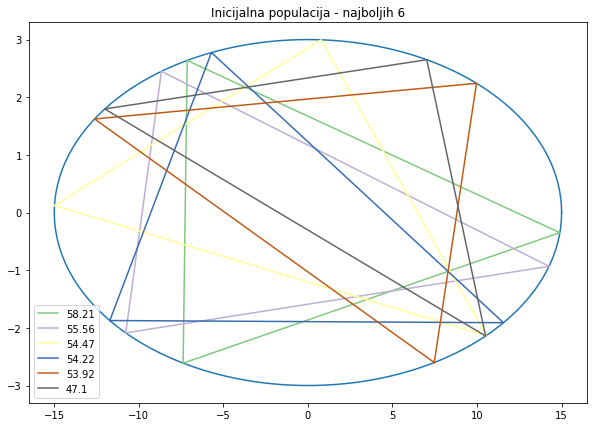

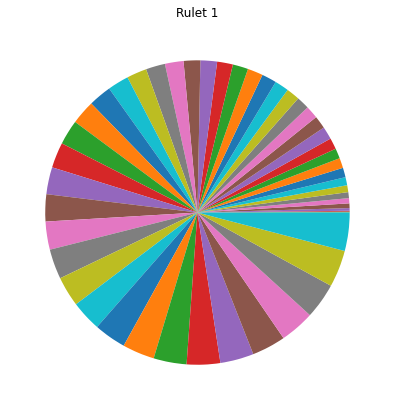

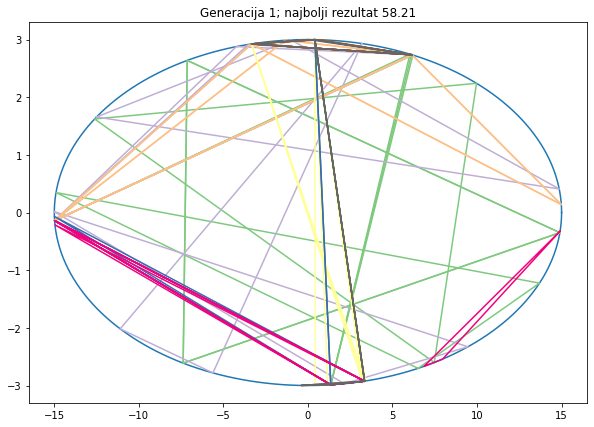

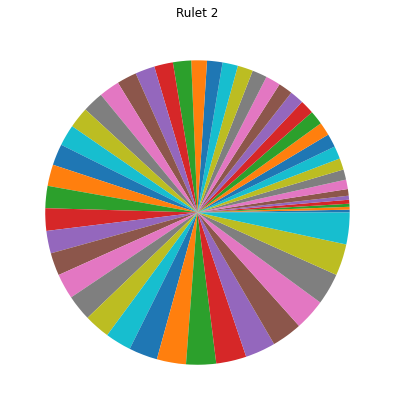

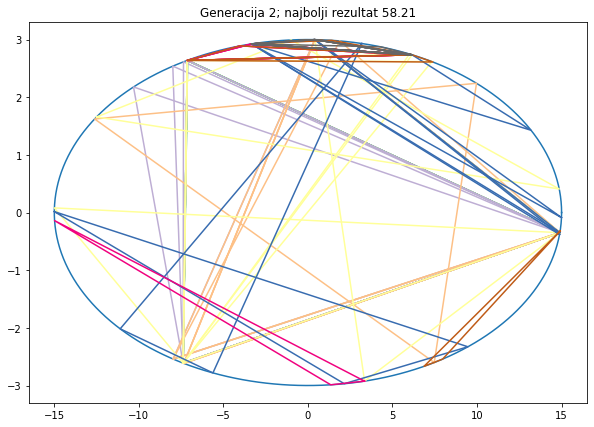

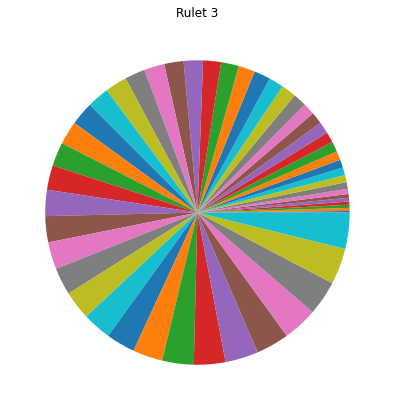

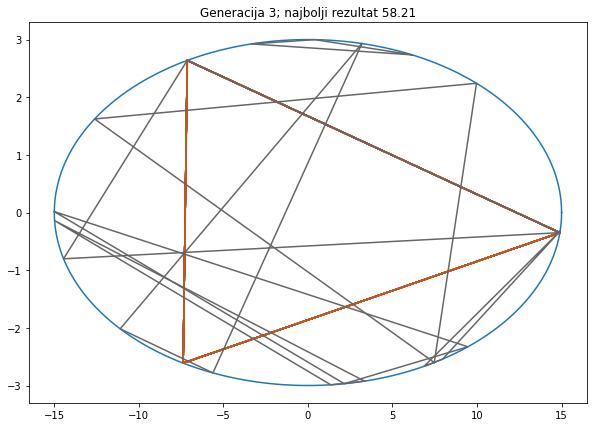

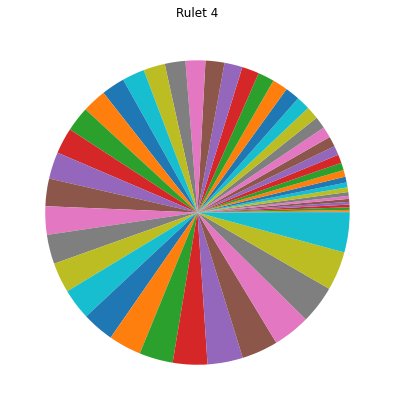

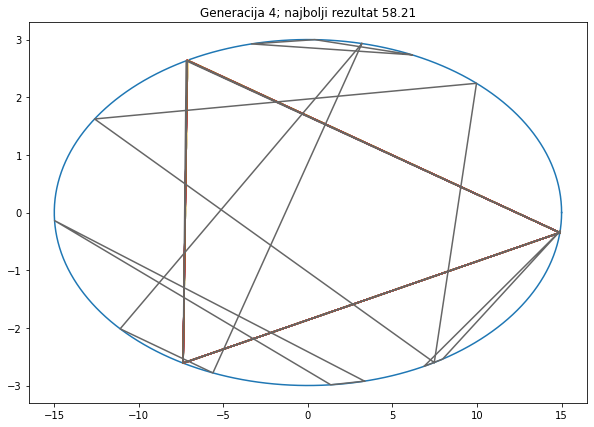

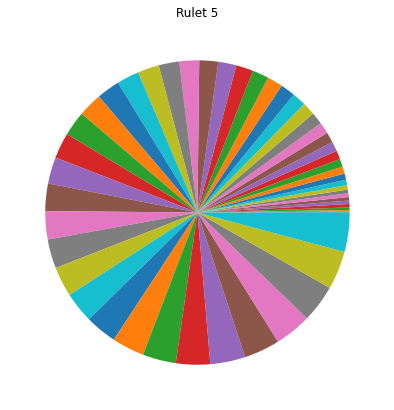

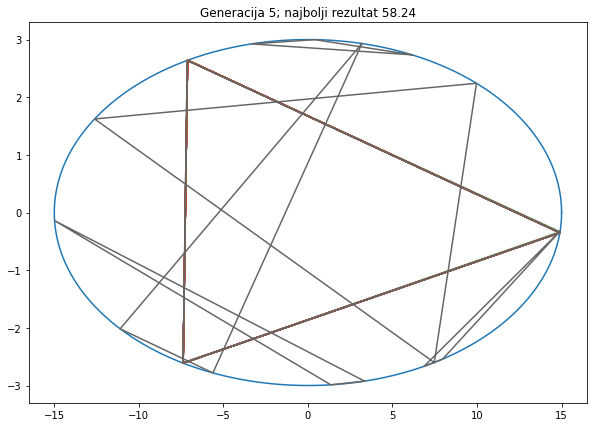

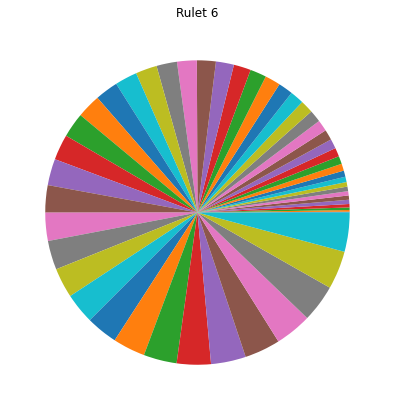

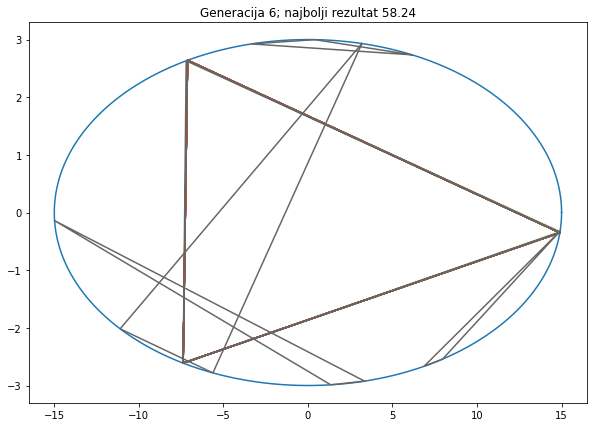

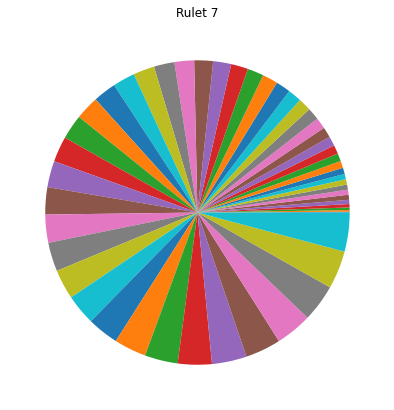

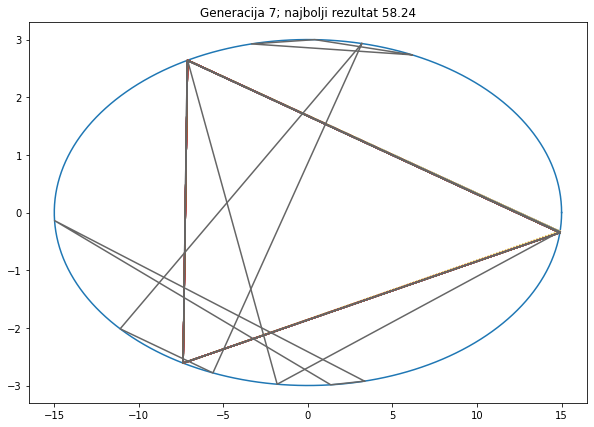

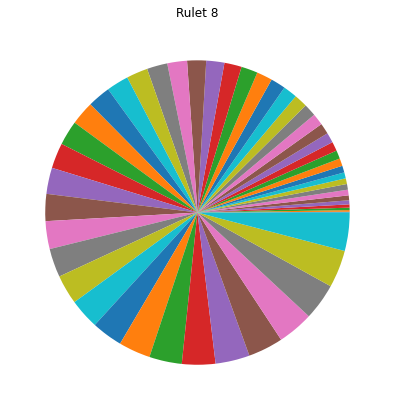

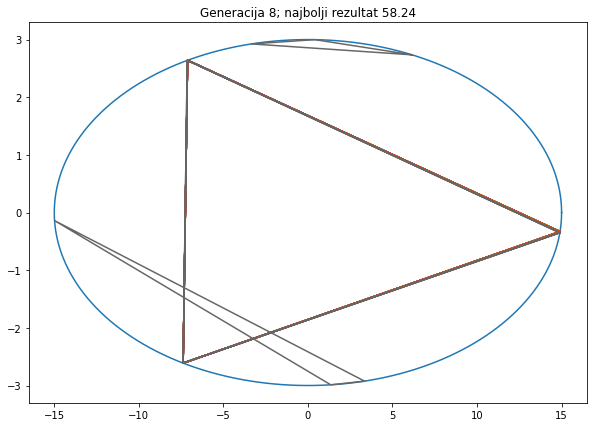

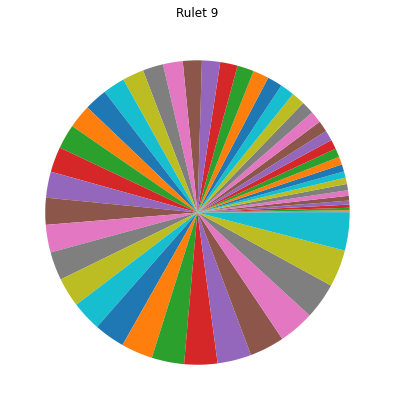

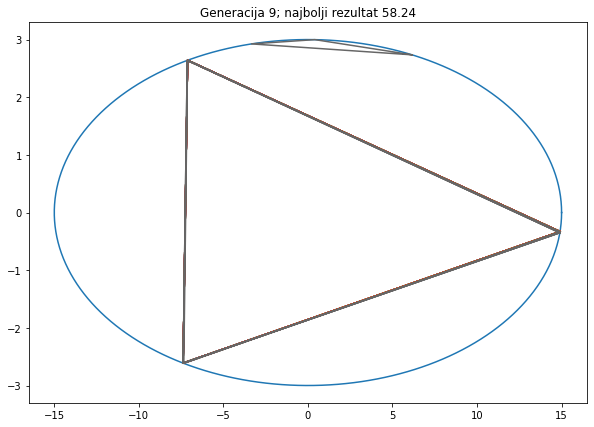

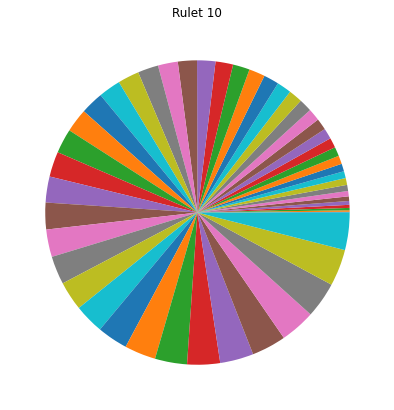

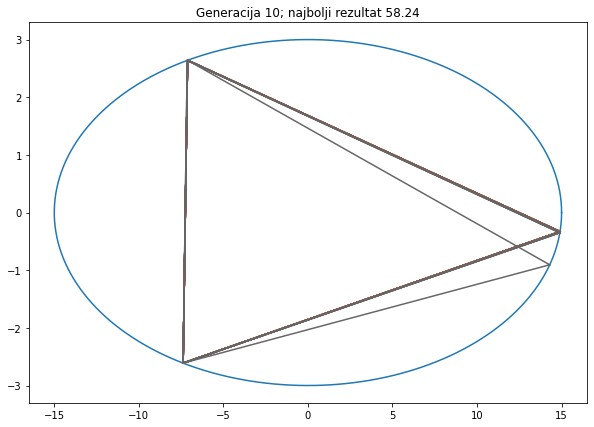

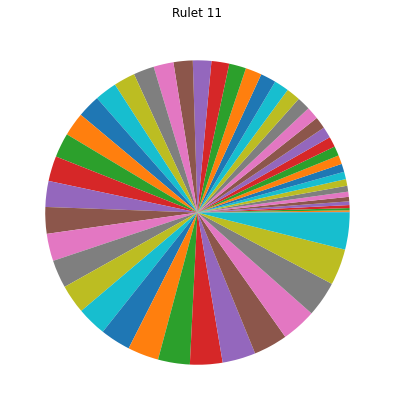

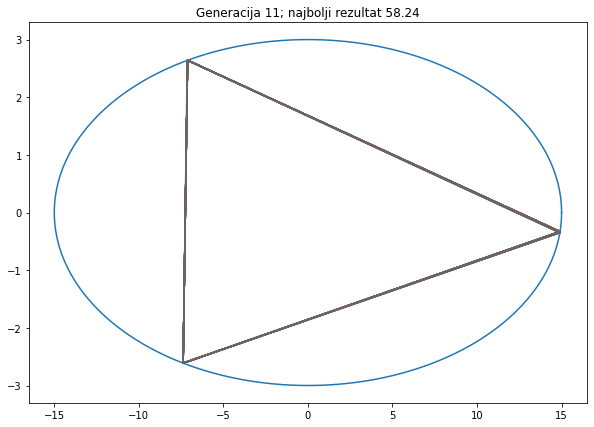

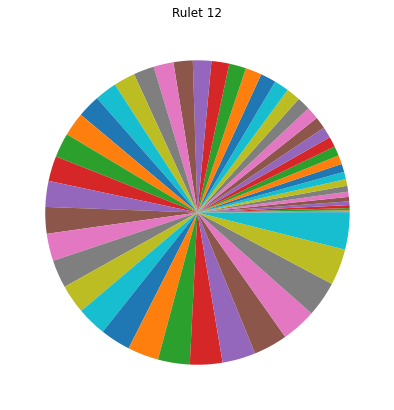

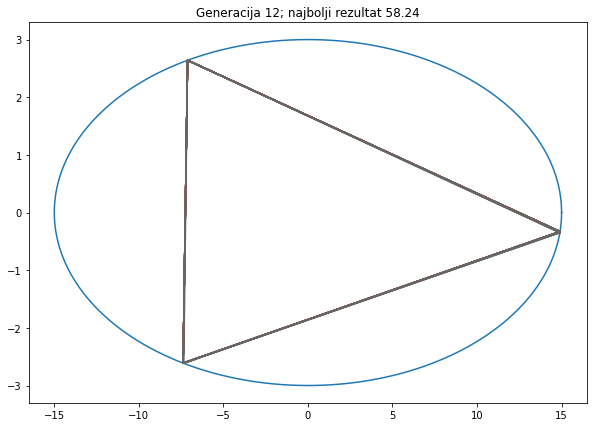

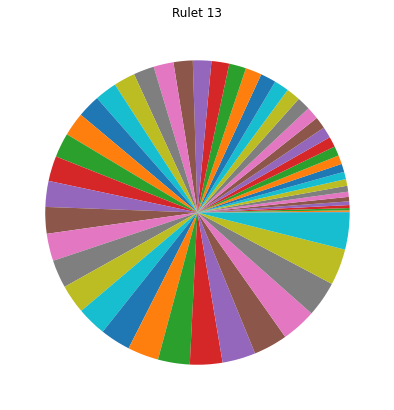

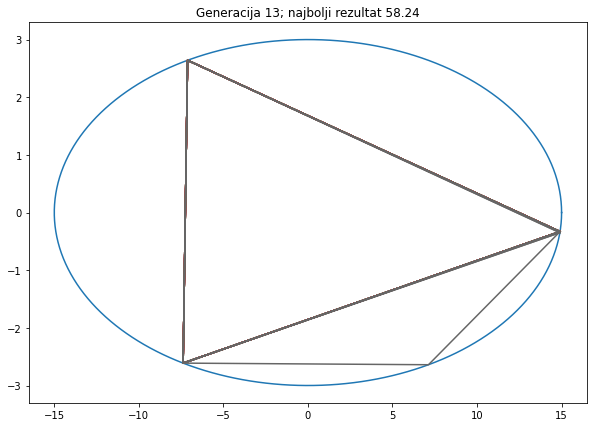

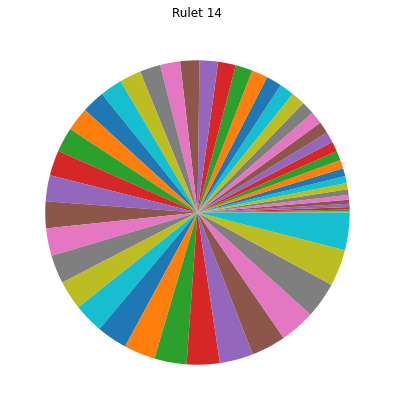

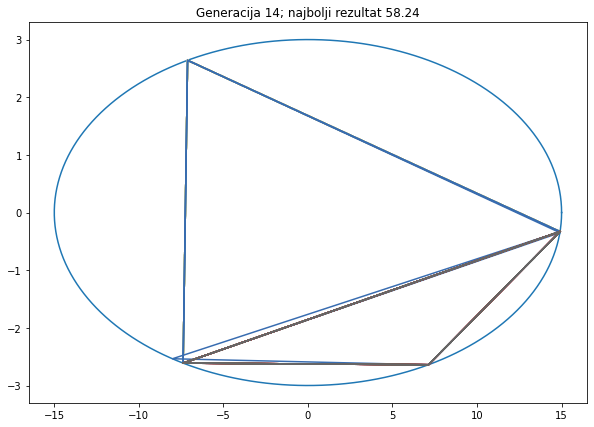

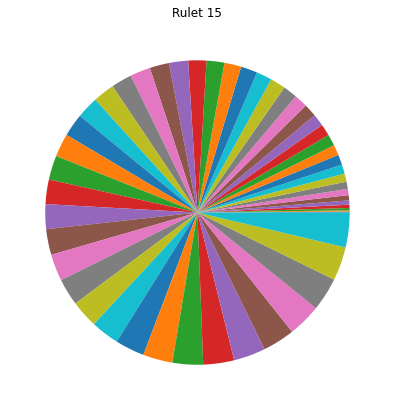

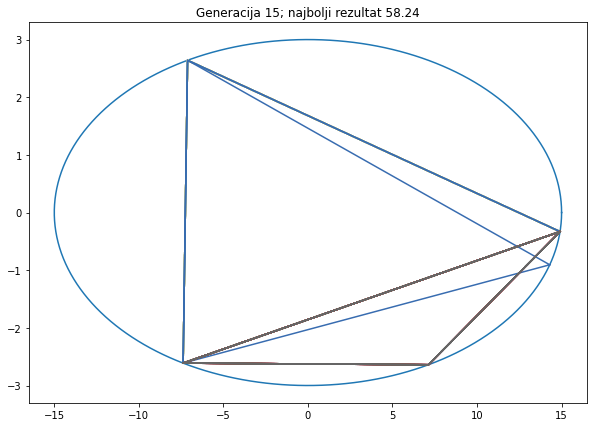

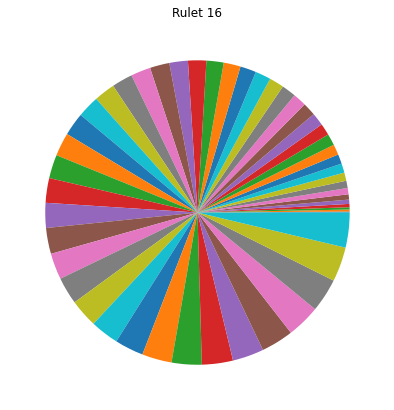

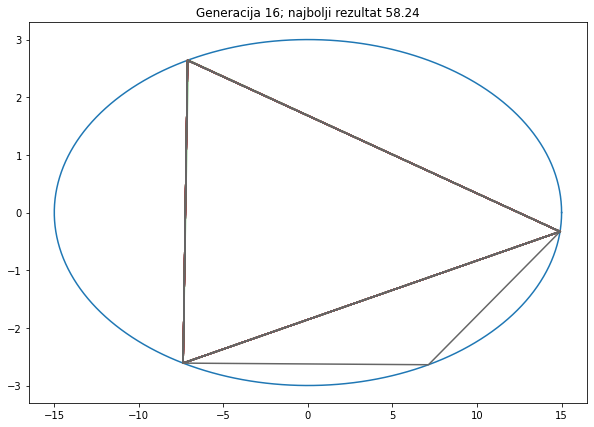

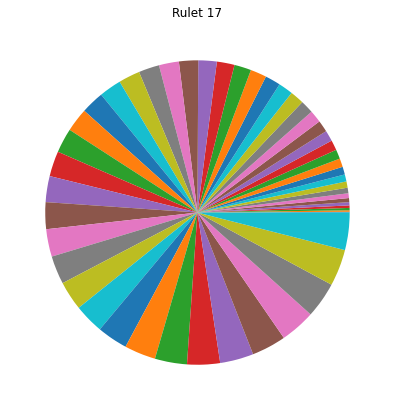

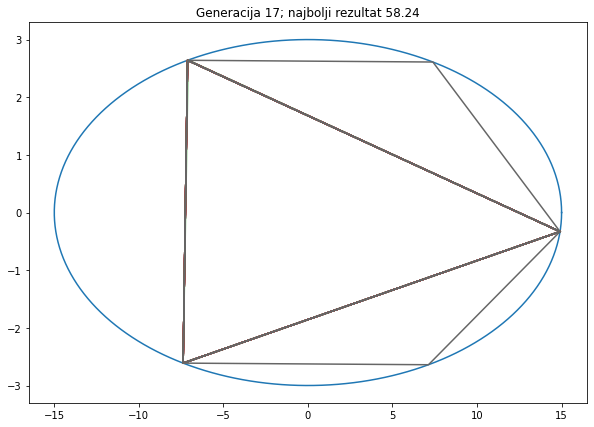

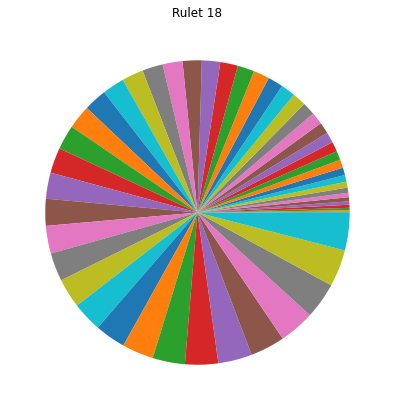

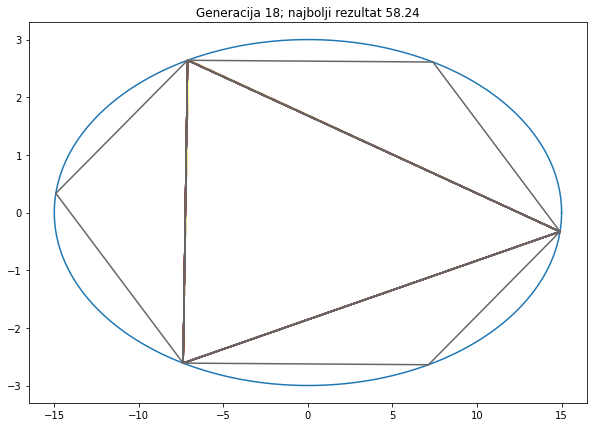

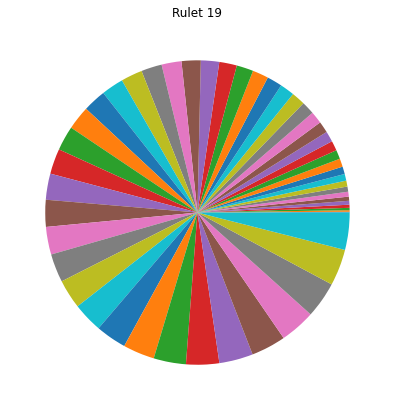

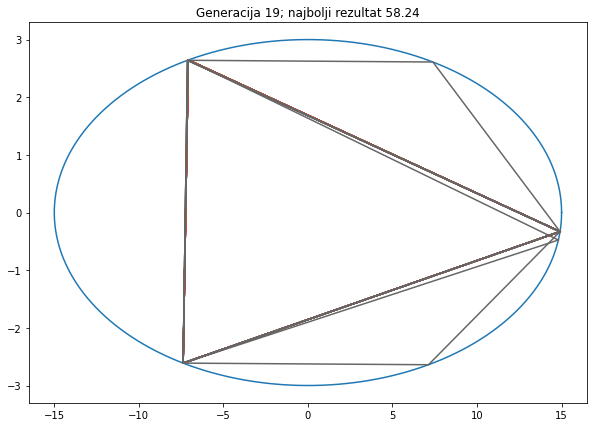

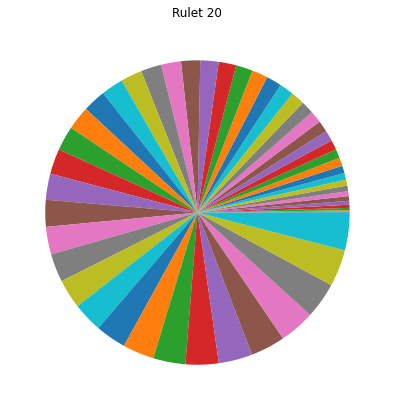

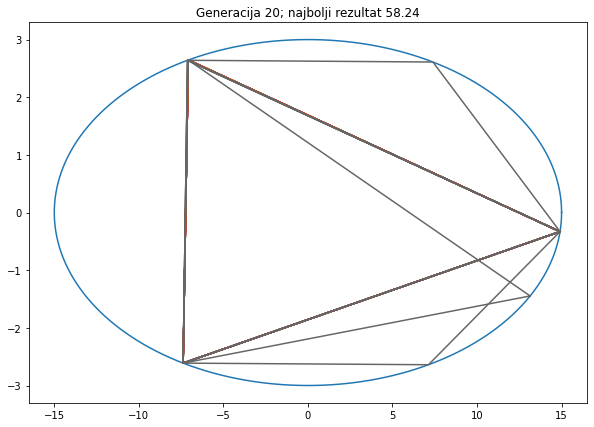

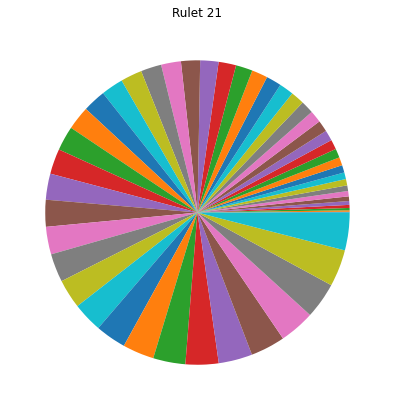

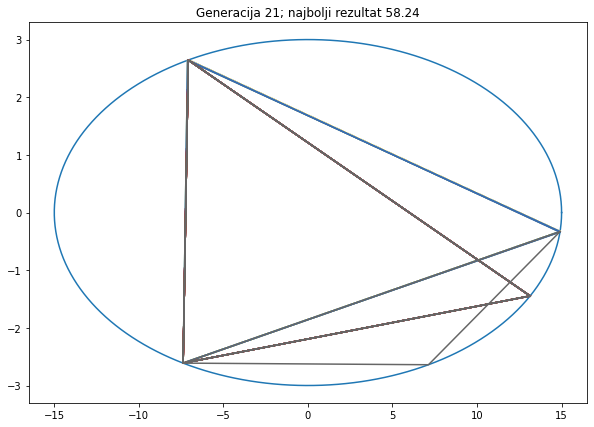

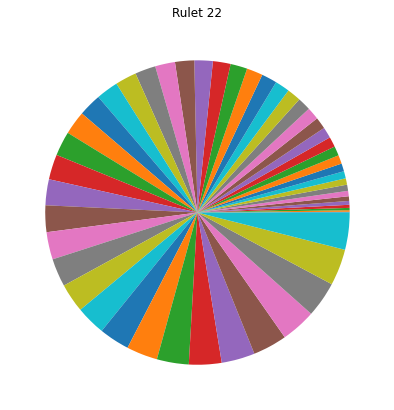

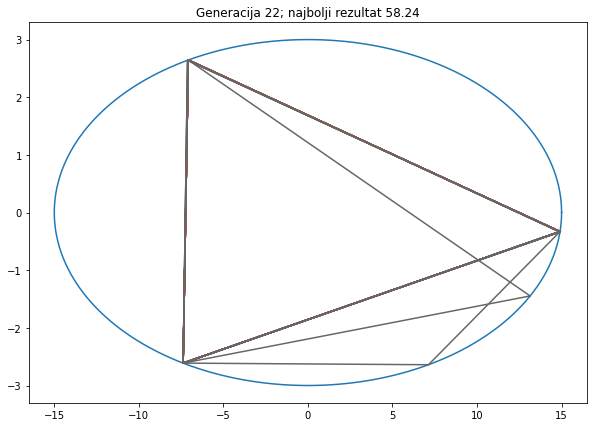

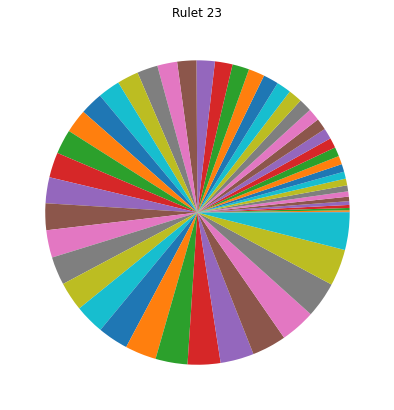

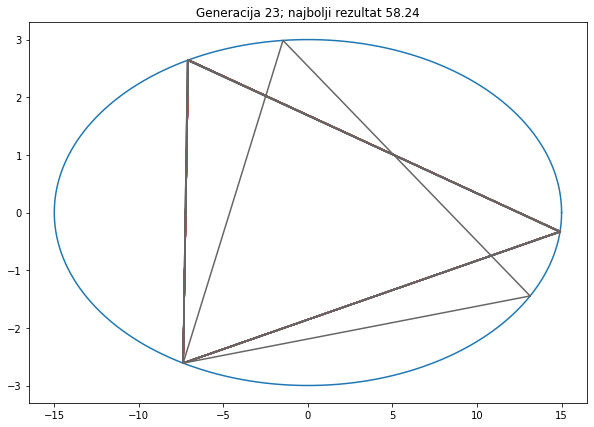

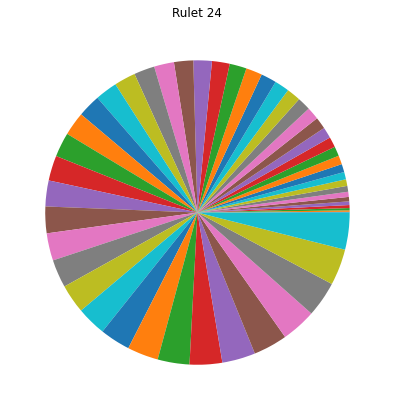

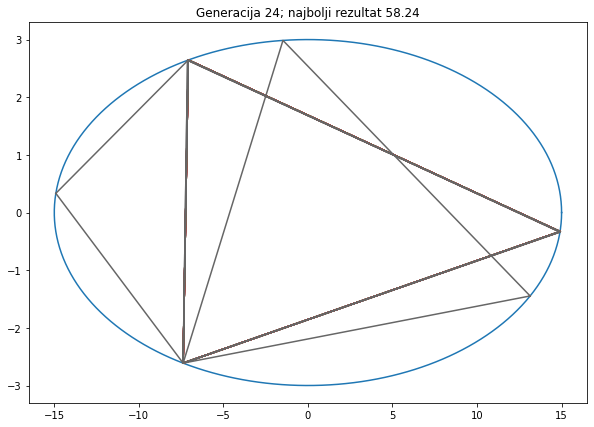

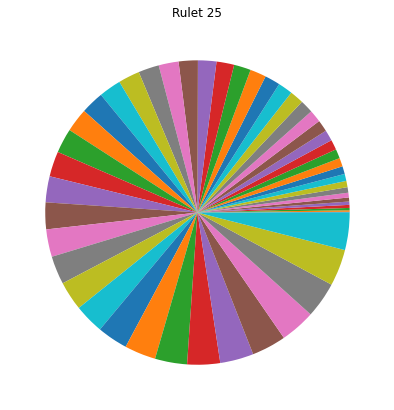

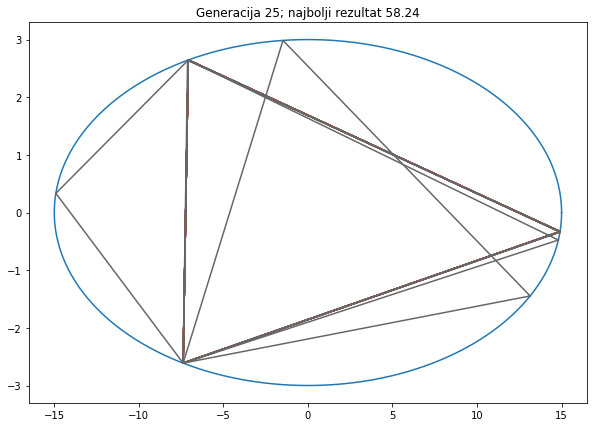

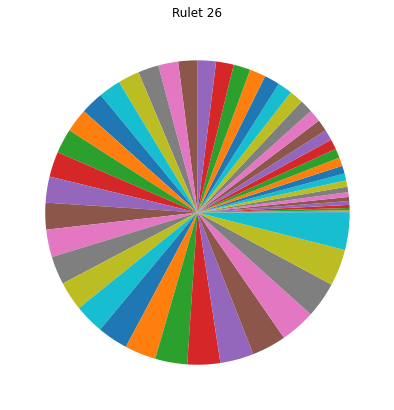

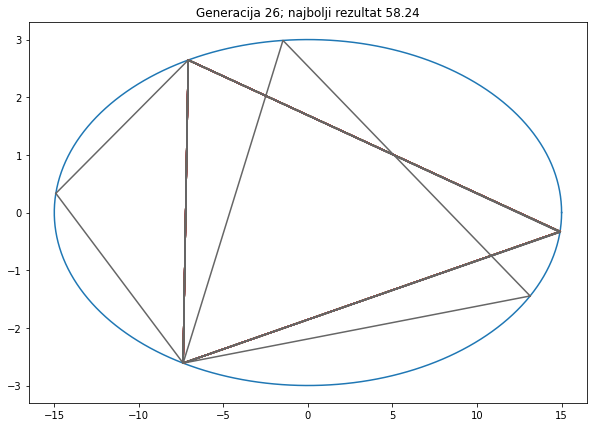

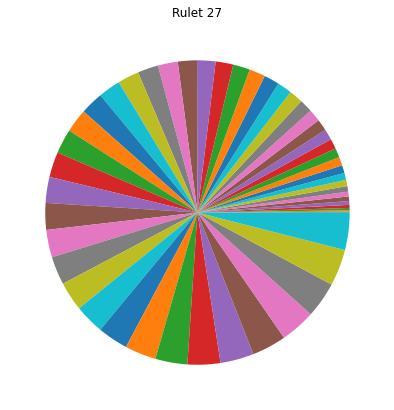

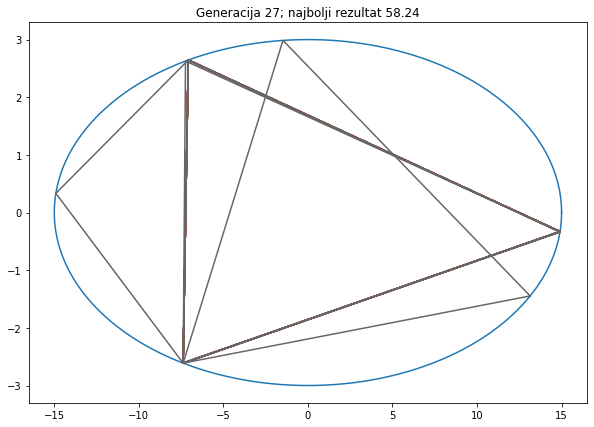

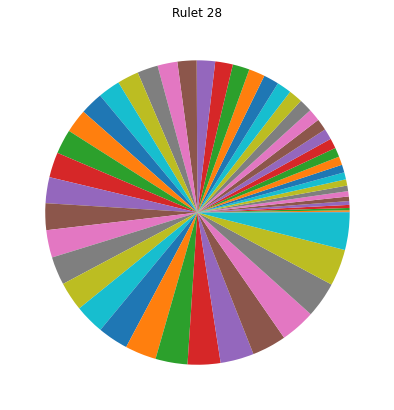

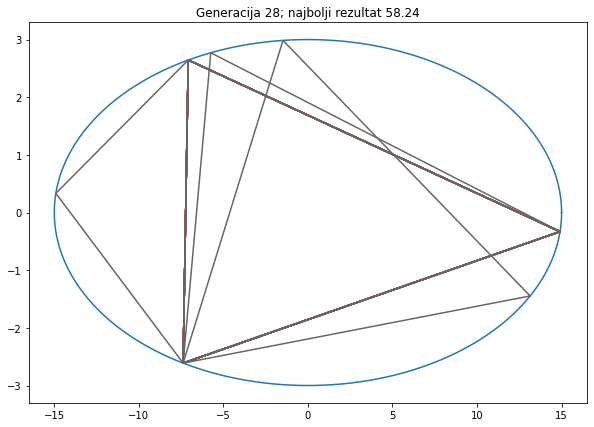

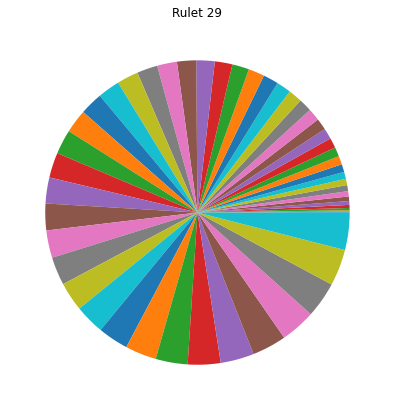

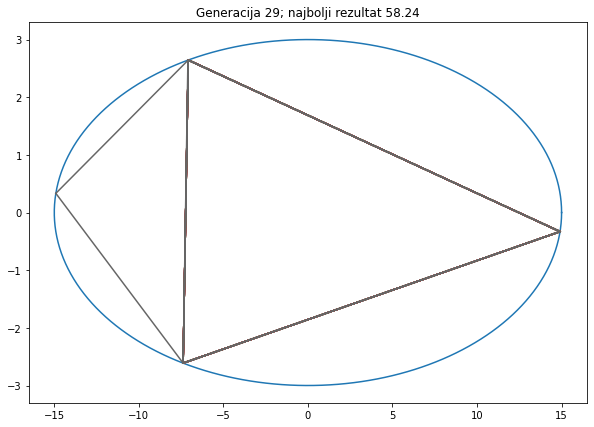

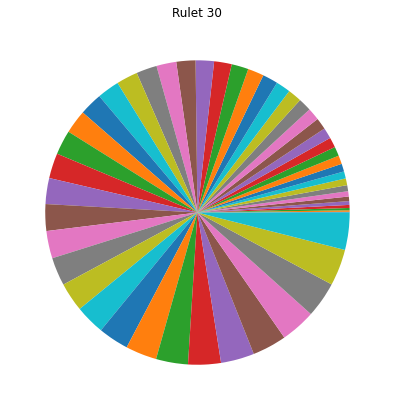

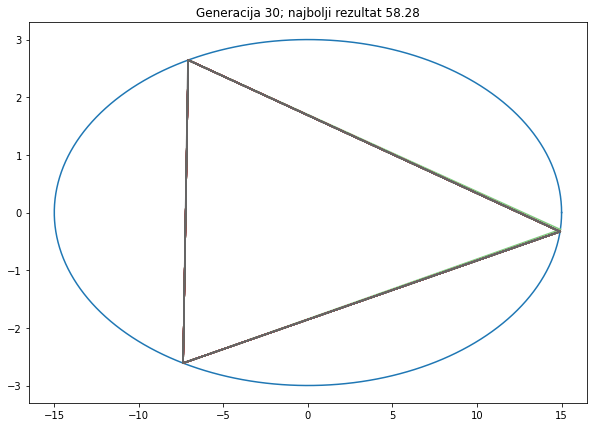

In [624]:
f_max = genetic_algorithm(N, L, G, pc, pm, a, b, iterations = 30)

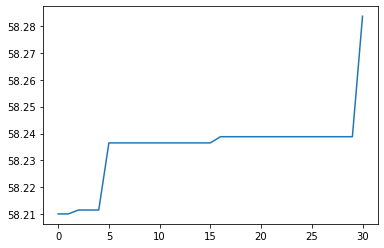

In [625]:
plt.plot(np.arange(0, f_max.shape[0]), f_max)

In [626]:
f_max

array([58.21005434, 58.21005434, 58.21151008, 58.21151008, 58.21151008,
       58.2365069 , 58.2365069 , 58.2365069 , 58.2365069 , 58.2365069 ,
       58.2365069 , 58.2365069 , 58.2365069 , 58.2365069 , 58.2365069 ,
       58.2365069 , 58.23880556, 58.23880556, 58.23880556, 58.23880556,
       58.23880556, 58.23880556, 58.23880556, 58.23880556, 58.23880556,
       58.23880556, 58.23880556, 58.23880556, 58.23880556, 58.23880556,
       58.28366814])